# Importing packages

In [1]:
import os
import numpy as np
import pandas as pd
from pandas_ods_reader import read_ods
import matplotlib.pyplot as plt

# Import files

In [5]:
os.chdir('/content/drive/MyDrive/New AutoMotive/Research & analysis/Charging device research 2021')

In [2]:
list_file=os.listdir() #Listing all files in the directory 

In [3]:
list_file

['.git',
 '.ipynb_checkpoints',
 'Data',
 'EV and charging devices uptake.ipynb',
 'README.md']

In [8]:
#Import file containing the information about, among others, postcodes, local authority, constituency and population
postcode = pd.read_csv('postcodes.csv') 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,17,18,21,22,24,25,29,32,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
postcode.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Introduced,Terminated,Parish,National Park,Population,Households,Built up area,Built up sub-division,Lower layer super output area,Rural/urban,Region,Altitude,London zone,LSOA Code,Local authority,MSOA Code,Middle layer super output area,Parish Code,Census output area,Constituency Code,Index of Multiple Deprivation,Quality,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district,Police force,Water company,Plus Code,Average Income,Sewage Company,Travel To Work Area
0,AB1 0AA,No,57.101474,-2.242851,385386.0,801193.0,NJ853011,NaN,Aberdeen City,Lower Deeside,S12000033,S13002843,Scotland,S99999999,Aberdeen South,1980-01-01,1996-06-01,NaN,NaN,NaN,NaN,NaN,NaN,"Cults, Bieldside and Milltimber West - 02",Accessible small town,NaN,46.0,NaN,S01006514,NaN,S02001237,"Cults, Bieldside and Milltimber West",NaN,S00090303,S14000002,6808.0,1.0,0.0,2020-11-21,Portlethen,8.31408,AB,AB1,Scotland,Scottish Water,9C9V4Q24+HV,NaN,NaN,Aberdeen
1,AB1 0AB,No,57.102554,-2.246308,385177.0,801314.0,NJ851013,NaN,Aberdeen City,Lower Deeside,S12000033,S13002843,Scotland,S99999999,Aberdeen South,1980-01-01,1996-06-01,NaN,NaN,NaN,NaN,NaN,NaN,"Cults, Bieldside and Milltimber West - 02",Accessible small town,NaN,61.0,NaN,S01006514,NaN,S02001237,"Cults, Bieldside and Milltimber West",NaN,S00090303,S14000002,6808.0,1.0,0.0,2020-11-21,Portlethen,8.55457,AB,AB1,Scotland,Scottish Water,9C9V4Q33+2F,NaN,NaN,Aberdeen
2,AB1 0AD,No,57.100556,-2.248342,385053.0,801092.0,NJ850010,NaN,Aberdeen City,Lower Deeside,S12000033,S13002843,Scotland,S99999999,Aberdeen South,1980-01-01,1996-06-01,NaN,NaN,NaN,NaN,NaN,NaN,"Cults, Bieldside and Milltimber West - 02",Accessible small town,NaN,45.0,NaN,S01006514,NaN,S02001237,"Cults, Bieldside and Milltimber West",NaN,S00090399,S14000002,6808.0,1.0,0.0,2020-11-21,Portlethen,8.54352,AB,AB1,Scotland,Scottish Water,9C9V4Q22+6M,NaN,NaN,Aberdeen
3,AB1 0AE,No,57.084444,-2.255708,384600.0,799300.0,NO845992,NaN,Aberdeenshire,North Kincardine,S12000034,S13002864,Scotland,S99999999,West Aberdeenshire and Kincardine,1994-02-01,1996-06-01,NaN,NaN,NaN,NaN,NaN,NaN,"Dunecht, Durris and Drumoak - 01",Accessible rural area,NaN,51.0,NaN,S01006853,NaN,S02001296,"Dunecht, Durris and Drumoak",NaN,S00091322,S14000058,5503.0,8.0,0.0,2020-11-21,Portlethen,8.20809,AB,AB1,Scotland,Scottish Water,9C9V3PMV+QP,NaN,NaN,Aberdeen
4,AB1 0AF,No,57.096656,-2.258102,384460.0,800660.0,NJ844006,NaN,Aberdeen City,Lower Deeside,S12000033,S13002843,Scotland,S99999999,Aberdeen South,1990-12-01,1992-07-01,NaN,NaN,NaN,NaN,NaN,NaN,Culter - 06,Accessible small town,NaN,46.0,NaN,S01006511,NaN,S02001236,Culter,NaN,S00090299,S14000002,6668.0,8.0,1.0,2020-11-21,Portlethen,8.85583,AB,AB1,Scotland,Scottish Water,9C9V3PWR+MQ,NaN,NaN,Aberdeen


In [13]:
#Removing unnecessary columns to reduce the size and, therefore, the computational power required to process the dataframe
postcode = postcode.drop(['Latitude', 'Longitude', 'Easting', 'Northing','Grid Ref','County','Introduced', 'Terminated',
       'Parish', 'National Park','Households', 'Built up area',
       'Built up sub-division', 'Lower layer super output area', 'Rural/urban',
       'Region', 'Altitude', 'London zone', 'LSOA Code', 'Local authority',
       'MSOA Code', 'Middle layer super output area', 'Parish Code',
       'Census output area', 'Index of Multiple Deprivation', 'Quality', 'User Type', 'Last updated',
       'Nearest station', 'Distance to station', 'Postcode area',
       'Postcode district', 'Police force', 'Water company', 'Plus Code',
       'Average Income', 'Sewage Company', 'Travel To Work Area'], axis = 1)

In [14]:
#Selecting only the postcodes that are still in use
postcode_sel = postcode.loc[postcode['In Use?']=='Yes'] 
postcode_sel.reset_index(inplace=True, drop=True)

In [15]:
postcode_sel.head()

,Postcode,In Use?,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Population,Constituency Code
0,AB10 1AB,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
1,AB10 1AF,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
2,AB10 1AG,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
3,AB10 1AH,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
4,AB10 1AL,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001


In [16]:
#Calculate the percentage of missing data in the dataframe

print('Missing {per:.2f}% of Postcode data'.format(per = postcode_sel['Postcode'].isnull().values.sum()/len(postcode_sel)*100)) 
print('Missing {per:.2f}% of District data'.format(per =postcode_sel['District'].isnull().values.sum()/len(postcode_sel)*100))
print('Missing {per:.2f}% of Constituency data'.format(per =postcode_sel['Constituency'].isnull().values.sum()/len(postcode_sel)*100))
print('Missing {per:.2f}% of Population data'.format(per =postcode_sel['Population'].isnull().values.sum()/len(postcode_sel)*100))

Missing 0.00% of Postcode data
Missing 0.08% of District data
Missing 0.08% of Constituency data
Missing 15.62% of Population data


In [19]:
#Replace NaN values in the population column with zeros
postcode_sel['Population'].fillna(0)

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
           ... 
1760648    46.0
1760649    27.0
1760650    28.0
1760651    23.0
1760652    56.0
Name: Population, Length: 1760653, dtype: float64

In [20]:
postcode_sel.head()

,Postcode,In Use?,District,Ward,District Code,Ward Code,Country,County Code,Constituency,Population,Constituency Code
0,AB10 1AB,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
1,AB10 1AF,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
2,AB10 1AG,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
3,AB10 1AH,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,NaN,S14000001
4,AB10 1AL,Yes,Aberdeen City,George St/Harbour,S12000033,S13002842,Scotland,S99999999,Aberdeen North,0.0,S14000001


In [22]:
#Calculate what is the percentage difference between the total UK population calculated using the data
#from the postcode_sel DataFrame and the actual value

population_sum = postcode_sel['Population'].sum()
uk_population = 66.65*10**6

print( 'Percentage difference in population {per:.2f} %'.format( per = abs(population_sum-uk_population)/uk_population*100 ))

Percentage difference in population 5.44 %


The realatively small difference between the values allows to categorise the missing information about the population as negligile overall. This, however, can still have a significant impact locally. 

In [23]:
#Create a list containing the name of the District associated with the postcodes. 
#These should correspond to the local authority names in the 'electric-vehicle-charging-device-statistics-october-2020' file. 

district = postcode_sel['District'].unique().tolist()

#district=[]
#for item in postcode_sel['District']:
 #   if item not in district:
  #      district.append(item)

In [24]:
#Remove any non string value from the district list
for item in district: 
    if not isinstance(item,str):
        district.remove(item)

In [25]:
#Create a list containing the name of the 650 UK constituencies. 

constituency = postcode_sel['Constituency'].unique().tolist() 

#constituency=[]
#for item in postcode_sel['Constituency']:
#    if item not in constituency:
#        constituency.append(item)

In [26]:
#Remove any non string value from the constituency list
for item in constituency: 
    if not isinstance(item,str):
        constituency.remove(item)

In [27]:
#Create a dictionary to associate each constituency with the corresponding population

dic_population = {item:int(postcode_sel.loc[postcode_sel['Constituency']==item]['Population'].sum()) for item in constituency}

In [28]:
#Create a dictionary to associate each constituency with the corresponding postcodes

dic_constituency = {item:'' for item in constituency}
for item in constituency: 
    list_val = postcode_sel.loc[postcode_sel['Constituency']==item]['Postcode'].values
    list_val_sel=[]
    for val in list_val:
        lval = val.split(' ')[0]
        if lval not in list_val_sel:
            list_val_sel.append(lval)
    dic_constituency[item] = list_val_sel

In [29]:
#Create a dictionary to associate each DISTRICT with the corresponding postcodes

dic_district = {item:'' for item in district}
for item in district: 
    list_val = postcode_sel.loc[postcode_sel['District']==item]['Postcode'].values
    list_val_sel=[]
    for val in list_val:
        lval = val.split(' ')[0]
        if lval not in list_val_sel:
            list_val_sel.append(lval)
    dic_district[item] = list_val_sel

In [30]:
#Create a dictionary to associate each DISTRICT with the corresponding population

dic_dist_population = {item:int(postcode_sel.loc[postcode_sel['District']==item]['Population'].sum()) for item in district}

In [31]:
#Create a dictionary to associate each constituency with the corresponding local authorities

dic_constituency_district = {item:'' for item in constituency}
for item in constituency: 
    list_val = postcode_sel.loc[postcode_sel['Constituency']==item]['District'].values
    list_val_sel=[]
    for val in list_val:
        if val not in list_val_sel:
            list_val_sel.append(val)
    dic_constituency_district[item] = list_val_sel

# Import public charging devices tables

In [32]:
dft_charging_devices_available = read_ods('electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_01', headers=False) 

In [33]:
dft_charging_devices_available.columns = dft_charging_devices_available.iloc[6].values #Assign the values on the 7th column as column names
dft_charging_devices_available = dft_charging_devices_available.iloc[7:-16,:] #Select only the rows with meaninging values in the table (i.e. removing text)
dft_charging_devices_available.reset_index(inplace=True, drop=True) #reset the index

In [34]:
dft_charging_devices_available.head()

,LA / Region Code,Local Authority / Region Name,Total public\ncharging devices,Total public rapid\ncharging devices,"Charging devices per\n100,000 population","Rapid Devices per\n100,000 population"
0,K02000001,UNITED KINGDOM,19487,3530,29.1736,5.28468
1,K03000001,GREAT BRITAIN,19169,3508,29.5348,5.40498
2,E92000001,ENGLAND,16456,2909,29.2359,5.16816
3,E12000001,NORTH EAST,849,156,31.7985,5.84283
4,E06000047,County Durham,106,15,19.9965,2.82969


In [35]:
print('Missing {per:.2f}% of entire data'.format(per = dft_charging_devices_available.isnull().values.sum()/len(dft_charging_devices_available)*100)) 

Missing 1.40% of entire data


In [36]:
dft_charging_devices_available = dft_charging_devices_available.dropna() #Removing rows containing NaN values 

In [37]:
dft_charging_devices_quarter = read_ods('electric-vehicle-charging-device-statistics-october-2020.ods', 'EVCD_02', headers=False) 
dft_charging_devices_quarter.columns = dft_charging_devices_quarter.iloc[6].values #Assign the values on the 7th column as column names
dft_charging_devices_quarter = dft_charging_devices_quarter.iloc[7:30,:-1] #Select only the rows with meaninging values in the table (i.e. removing text)
dft_charging_devices_quarter.reset_index(inplace=True, drop=True)
dft_charging_devices_quarter = dft_charging_devices_quarter.fillna(method='ffill')
dft_charging_devices_quarter.head()

,Year,Quarter,Total Devices,Rapid Devices
0,2015.0,Q1,2664.0,249.0
1,2015.0,Q2,2910.0,301.0
2,2015.0,Q3,3248.0,431.0
3,2015.0,Q4,3672.0,693.0
4,2016.0,Q1,3916.0,781.0


In [38]:
dft_charging_devices_quarter.tail()

,Year,Quarter,Total Devices,Rapid Devices
18,2019.0,Q3,15116.0,2495.0
19,2019.0,Q4,16505.0,2829.0
20,2020.0,Q1,17947.0,3107.0
21,2020.0,Q2,18265.0,3206.0
22,2020.0,Q3,19487.0,3530.0


In [39]:
df_charges_quarter = pd.DataFrame(dft_charging_devices_quarter['Total  Devices'])
df_charges_quarter['Time'] = [str(j)+' '+'Q'+str(i)  for j in range(2015,2021) for i in range(1,5)][:-1]
df_charges_quarter =  df_charges_quarter.set_index('Time')

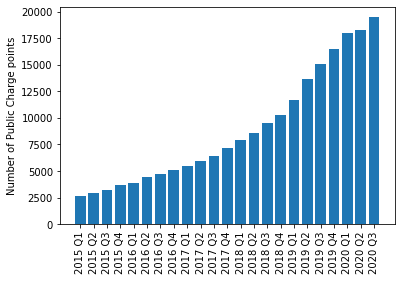

In [40]:
## Plot the trend of the publicly available charging devices in the UK between Q1 2015 and Q3 2020 ##

plt.bar(df_charges_quarter.index,df_charges_quarter['Total  Devices'],.8)
plt.xticks(rotation = 90)
plt.ylabel('Number of Public Charge points')
plt.show()

# Import vehicles tables

In [52]:
#Import Ultra Low Emission Vehicles (ULEVs) table
dft_ulev_import = read_ods('veh0134.ods', 'VEH0134a')
dft_ulev = dft_ulev_import[6:-14]
dft_ulev.columns = dft_ulev_import.iloc[5].values
dft_ulev.reset_index(inplace=True, drop=True)

In [53]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_ulev[dft_ulev['2020 Q3']=='c'])/len(dft_ulev)*100) )

Missing 0.27% of entire data


In [54]:
dft_ulev = dft_ulev.replace({'c':0}) # Replace the c values with zeros so that the statistics is not altered 

In [95]:
#Import Battery Electric Vehicles (BEVs) table by postcode
dft_bev_import = read_ods('veh0134.ods', 'VEH0134b')
dft_bev = dft_bev_import[6:-14]
dft_bev.columns = dft_bev_import.iloc[5].values
dft_bev.reset_index(inplace=True, drop=True)

In [104]:
#Import Battery Electric Vehicles (BEVs) table by LA
dft_bev_la_import = read_ods('veh0132.ods', 'VEH0132b')
dft_bev_la = dft_bev_la_import[6:-14]
dft_bev_la.columns = dft_bev_la_import.iloc[5].values
dft_bev_la.reset_index(inplace=True, drop=True)

In [102]:
len(district)

379

In [110]:
dft_bev_la.columns

Index(['ONS LA Code', 'Region/Local Authority', '2020 Q3', '2020 Q2',
       '2020 Q1', '2019 Q4', '2019 Q3', '2019 Q2', '2019 Q1', '2018 Q4',
       '2018 Q3', '2018 Q2', '2018 Q1', '2017 Q4', '2017 Q3', '2017 Q2',
       '2017 Q1', '2016 Q4', '2016 Q3', '2016 Q2', '2016 Q1', '2015 Q4',
       '2015 Q3', '2015 Q2', '2015 Q1', '2014 Q4', '2014 Q3', '2014 Q2',
       '2014 Q1', '2013 Q4', '2013 Q3', '2013 Q2', '2013 Q1', '2012 Q4',
       '2012 Q3', '2012 Q2', '2012 Q1', '2011 Q4'],
      dtype='object')

In [114]:
type(district)

list

In [117]:
district[0]

'Aberdeen City'

In [130]:
dft_bev_la.iloc[420]['Region/Local Authority'].strip() in district

True

In [116]:
dft_bev_la[dft_bev_la['Region/Local Authority']==district[0]]

,ONS LA Code,Region/Local Authority,2020 Q3,2020 Q2,2020 Q1,2019 Q4,2019 Q3,2019 Q2,2019 Q1,2018 Q4,2018 Q3,2018 Q2,2018 Q1,2017 Q4,2017 Q3,2017 Q2,2017 Q1,2016 Q4,2016 Q3,2016 Q2,2016 Q1,2015 Q4,2015 Q3,2015 Q2,2015 Q1,2014 Q4,2014 Q3,2014 Q2,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4


In [56]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_bev[dft_bev['2020 Q3']=='c'])/len(dft_bev)*100))

Missing 2.43% of entire data


In [57]:
dft_bev = dft_bev.replace({'c':0})

In [58]:
dft_bev.head()

,Postcode District 2,2020 Q3,2020 Q2,2020 Q1,2019 Q4,2019 Q3,2019 Q2,2019 Q1,2018 Q4,2018 Q3,2018 Q2,2018 Q1,2017 Q4,2017 Q3,2017 Q2,2017 Q1,2016 Q4,2016 Q3,2016 Q2,2016 Q1,2015 Q4,2015 Q3,2015 Q2,2015 Q1,2014 Q4,2014 Q3,2014 Q2,2014 Q1,2013 Q4,2013 Q3,2013 Q2,2013 Q1,2012 Q4,2012 Q3,2012 Q2,2012 Q1,2011 Q4
0,AB10,27.0,20.0,24.0,19.0,18.0,17.0,17.0,14.0,14.0,12.0,9.0,9.0,8.0,6.0,7.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AB11,28.0,24.0,21.0,21.0,19.0,18.0,17.0,15.0,14.0,14.0,15.0,10.0,9.0,8.0,6.0,5.0,0.0,0.0,0.0,6.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AB12,68.0,52.0,58.0,45.0,41.0,36.0,32.0,29.0,24.0,24.0,22.0,22.0,24.0,24.0,25.0,20.0,21.0,22.0,19.0,15.0,14.0,8.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AB13,10.0,9.0,11.0,11.0,10.0,9.0,9.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AB14,15.0,10.0,10.0,10.0,9.0,7.0,7.0,6.0,5.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
dft_bev_nhb = dft_bev.set_index('Postcode District 2')

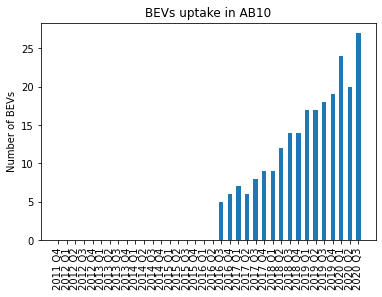

In [88]:
##Plot the NEIGHBOURHOOD level (i.e. Partial Postcode) of BEVs uptake for 

nhb_val = 'AB10'
nhb_sel = dft_bev_nhb.loc[nhb_val].reindex(index=dft_bev_nhb.loc[nhb_val].index[::-1])
plt.bar(nhb_sel.index,nhb_sel,.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.title('BEVs uptake in '+nhb_val)
plt.show() 

In [48]:
dft_bev_all = pd.DataFrame(dft_bev.sum()[1:], columns = ['Total BEVs']) # Sum the number of vehicles for each postcode to obtain the total number of BEVs in UK between Q4 2011 and Q3 2020 
dft_bev_all = dft_bev_all.reindex(index=dft_bev_all.index[::-1]) # Sort the index (Time) in ascending order 
dft_bev_all.index.names =['Time']

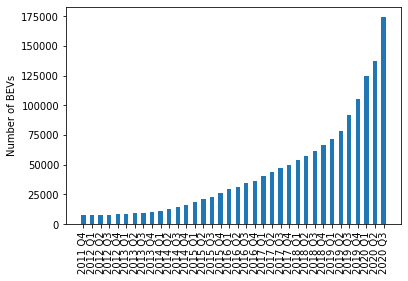

In [49]:
## Plot the NATIONAL trend of the number of BEVs in the UK between Q4 2011 and Q3 2020 ##

plt.bar(dft_bev_all.index,dft_bev_all['Total BEVs'],.5)
plt.xticks(rotation = 90)
plt.ylabel('Number of BEVs')
plt.show()

In [83]:
dft_bev_dist = pd.DataFrame([dft_bev[dft_bev['Postcode District 2'].isin(dic_district[item])].sum() for item in district])
dft_bev_dist['Postcode District 2'] = district
dft_bev_dist = dft_bev_dist.set_index('Postcode District 2')

In [ ]:
#Import Plug-in Hybrid Electric Vehicles (PHEVs) data
dft_phev_import = read_ods('veh0134.ods', 'VEH0134c')
dft_phev = dft_phev_import[6:-14]
dft_phev.columns = dft_phev_import.iloc[5].values
dft_phev.reset_index(inplace=True, drop=True)

In [ ]:
print('Missing {per:.2f}% of entire data'.format(per = len(dft_phev[dft_phev['2020 Q3']=='c'])/len(dft_phev)*100))

Missing 4.56% of entire data


In [ ]:
dft_phev = dft_phev.replace({'c':0})

# Import funding data

In [ ]:
fund_df = pd.read_excel("EIR E0019012.xlsx")
fund_df.columns = fund_df.iloc[7].values
fund_df = fund_df[8:].dropna(axis =1) #Remove a column containing only NaN values
fund_df.reset_index(inplace=True, drop=True)

In [ ]:
fund_df.head()

,Postcode District,EVHS Grants,DRS Grants
0,AB1,0,0
1,AB10,17,…
2,AB11,…,0
3,AB12,59,…
4,AB13,19,…


In [ ]:
# As stated in the file, all postcode districts with counts of at least one but fewer than ten have are indicated as "…".
#For statistical purpose, a lower estimate of this value is 1 and therefore "…" is replaced by the value 1. 
fund_df = fund_df.replace({'…':1})

# Create a DataFrame containing the necessary information per Local Authority



In [ ]:
#Define functions to compare different information contained in the DataFrame and format the output 

def receive_funding(private_charging_devices):
    if private_charging_devices>0:
        return 'Yes'
    else: 
        return 'No'

def private_or_public_charging(private_devices,electric_cars):
    if private_devices >= electric_cars: 
        return 'Predomintantly private'
    else: 
        return 'Predomintantly public'
def above_or_below_national_average(constituency_value, national_average):
    if constituency_value > national_average: 
        return 'Above national average'
    elif constituency_value == national_average: 
        return 'In line with national average'
    else: 
        return 'Below national average'
def print_summary(con_name): 
    constituency_charging_devices_density = summary_dataframe.loc[con_name]['Total public charging devices']/summary_dataframe.loc[con_name]['Population']
    constituency_ev_value = summary_dataframe.loc[con_name]['Total electric vehicles (BEVs)']
    constituency_charging_value = summary_dataframe.loc[con_name]['Total public charging devices']
    constituency_charging_ev_density = constituency_charging_value/constituency_ev_value
    
    return print('\nThe '+con_name+' local authority is:\n a) ' +  above_or_below_national_average(constituency_charging_devices_density,national_charging_devices_density) +' for Public charging devices per person \n b) '+  above_or_below_national_average(constituency_ev_value,constiutency_ev_density) +' for EV owners per constituency \n c) '+ above_or_below_national_average(constituency_charging_ev_density,national_charging_ev_density) +' Public charging devices per EV owner')

In [ ]:
columns_name = ['District','Population','Total electric vehicles (BEVs)','Total public charging devices','Total public charging devices per 100,000 population','Total private charging devices', 'Received government funding for residential charging devices','Charging devices usage']
summary_dataframe = pd.DataFrame({item:[] for item in columns_name})

In [ ]:
#Create a loop to populate the DataFrame for each constituency with information about the population, 
#total number of electric vehicles, total public charging devices (including rapid), total public charging devices (including rapid) per 100,000 population,
#total private charging devices, whether the constituency received government funding for residential charging devices and 
#the predomintant charging devices usage.

for area in district:
    total_electric_vehicles = dft_bev[dft_bev['Postcode District 2'].isin(dic_district[area])]['2020 Q3'].sum() #+ dft_phev[dft_phev['Postcode District 2'].isin(dic_district[area])]['2020 Q1'].sum()
    public_charging_devices,rapid_charging_devices,public_charging_devices_density,rapid_charging_devices_density = dft_charging_devices_available[dft_charging_devices_available['Local Authority / Region Name']==area][['Total public\ncharging devices','Total public rapid\ncharging devices','Charging devices per\n100,000 population','Rapid Devices per\n100,000 population']].mean()
    evhs_grant,drs_grant =fund_df[fund_df['Postcode District'].isin(dic_district[area])][['EVHS Grants','DRS Grants']].sum()

    total_population = dic_dist_population[area]
    total_public_charging_devices = public_charging_devices #+ rapid_charging_devices
    total_public_charging_devices_density = public_charging_devices_density# + rapid_charging_devices_density
    total_private_charging_devices = evhs_grant + drs_grant
    fundings = receive_funding(total_private_charging_devices)
    charging_devices_usage = private_or_public_charging(total_private_charging_devices, total_electric_vehicles)

    summary_dataframe = summary_dataframe.append(pd.DataFrame([[area,total_population,total_electric_vehicles,total_public_charging_devices,total_public_charging_devices_density,total_private_charging_devices,fundings,charging_devices_usage]], columns = columns_name))
    
summary_dataframe = summary_dataframe.set_index('District') # Set the Districy name as the DataFrame index

In [ ]:
#Calculate the national average values for:
#a) The number of public charging devices per person
#b) EV owners per constituency
#c) Number of public charging devices per EV owner

national_charging_devices = dft_charging_devices_available.loc[0]['Total public\ncharging devices']#+dft_charging_devices_available.loc[0]['Total public rapid\ncharging devices']
national_population = uk_population
national_charging_devices_density = national_charging_devices/national_population
national_ev = dft_bev['2020 Q3'].sum() +dft_phev['2020 Q3'].sum()
constiutency_ev_density = summary_dataframe['Total electric vehicles (BEVs)'].mean()
national_charging_ev_density = national_charging_devices/national_ev

# Print the summary of the required information

In [ ]:
df_charges_bev = pd.concat([df_charges_quarter,dft_bev_all], axis = 1, join = 'inner')

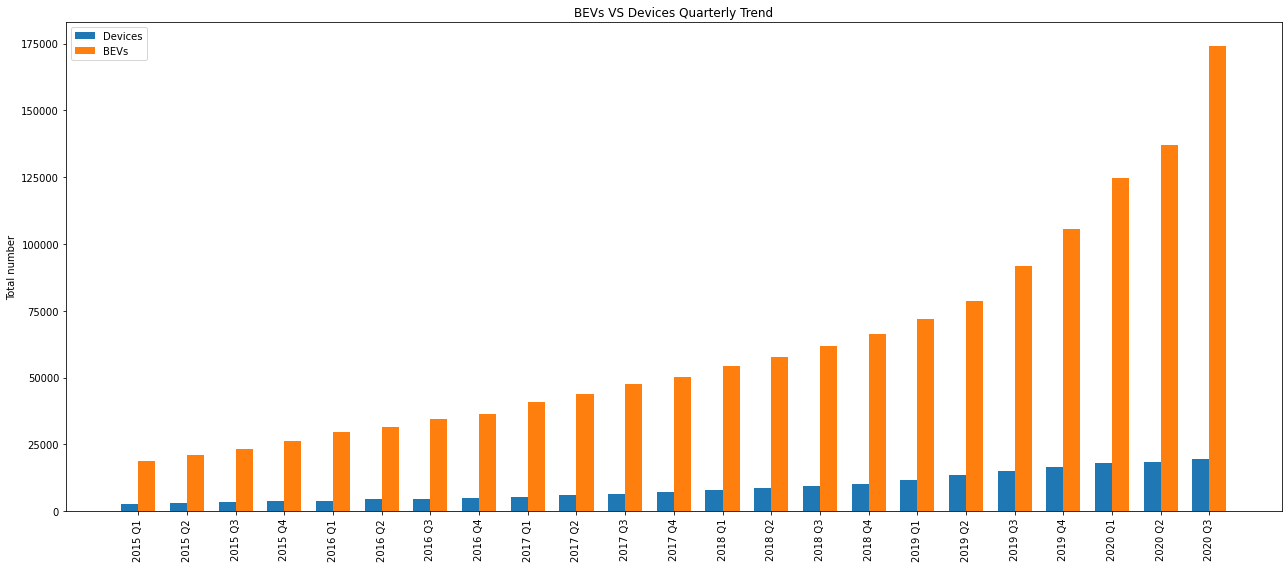

In [ ]:
x = np.arange(len(df_charges_bev.index))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
rects1 = ax.bar(x - width/2, df_charges_bev['Total  Devices'], width, label='Devices')
rects2 = ax.bar(x + width/2, df_charges_bev['Total BEVs'], width, label='BEVs')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total number')
ax.set_title('BEVs VS Devices Quarterly Trend')
ax.set_xticks(x)
ax.set_xticklabels(df_charges_bev.index, rotation = 90)
ax.legend()

fig.tight_layout()

plt.show()
fig.savefig('Devices_BEVs_comparision.png', bbox_inches='tight', dpi = 300)

In [ ]:
##Lookup table for each local authority number of EVs, public and private charging devices 
la_name = 'Watford'
print('Summary for the '+la_name+' Local Authority:\n')
print(summary_dataframe.loc[la_name])
print_summary(la_name)

Summary for the Watford Local Authority:

Population                                                                      90182
Total electric vehicles (BEVs)                                                   2806
Total public charging devices                                                      38
Total public charging devices per 100,000 population                          39.3468
Total private charging devices                                                    632
Received government funding for residential charging devices                      Yes
Charging devices usage                                          Predomintantly public
Name: Watford, dtype: object

The Watford local authority is:
 a) Above national average for Public charging devices per person 
 b) Above national average for EV owners per constituency 
 c) Below national average Public charging devices per EV owner


In [ ]:
#Subselect for the dataframe the local authorities where there are more EVs than private chargers 
ratios = summary_dataframe['Total electric vehicles (BEVs)']/summary_dataframe['Total private charging devices']
rsel=ratios[ratios!=np.inf]
rsel=rsel[rsel>1]

In [ ]:
rsel

District
Aberdeen City        1.101512
Aberdeenshire        1.030233
Angus                1.522634
Moray                1.763889
Highland             1.731183
                      ...    
Hounslow             2.806052
Watford              4.439873
Worcester            1.923513
York                 1.064449
Shetland Islands    14.500000
Length: 141, dtype: float64

In [ ]:
rsel_withoutmax = rsel.drop(rsel.idxmax())

In [ ]:
rsel_withoutmax.idxmax()

'Hackney'

In [ ]:
rsel_withoutmax.max()

15.704918032786885

In [ ]:
#Average values for the BEVs/Private chargers > 1 including and excluding the maximum value, respectively 
print(rsel.mean())
print(rsel_withoutmax.mean())

3.448621859055634
2.444683443763175


In [ ]:
#Median values for the BEVs/Private chargers > 1 including and excluding the maximum value, respectively 
print(rsel.median())
print(rsel_withoutmax.median())

1.3754152823920265
1.373060263257496


In [ ]:
#Standard Deviation values for the BEVs/Private chargers > 1 including and excluding the maximum value, respectively 
print(rsel.std())
print(rsel_withoutmax.std())

12.222794272847603
2.7085571193134714


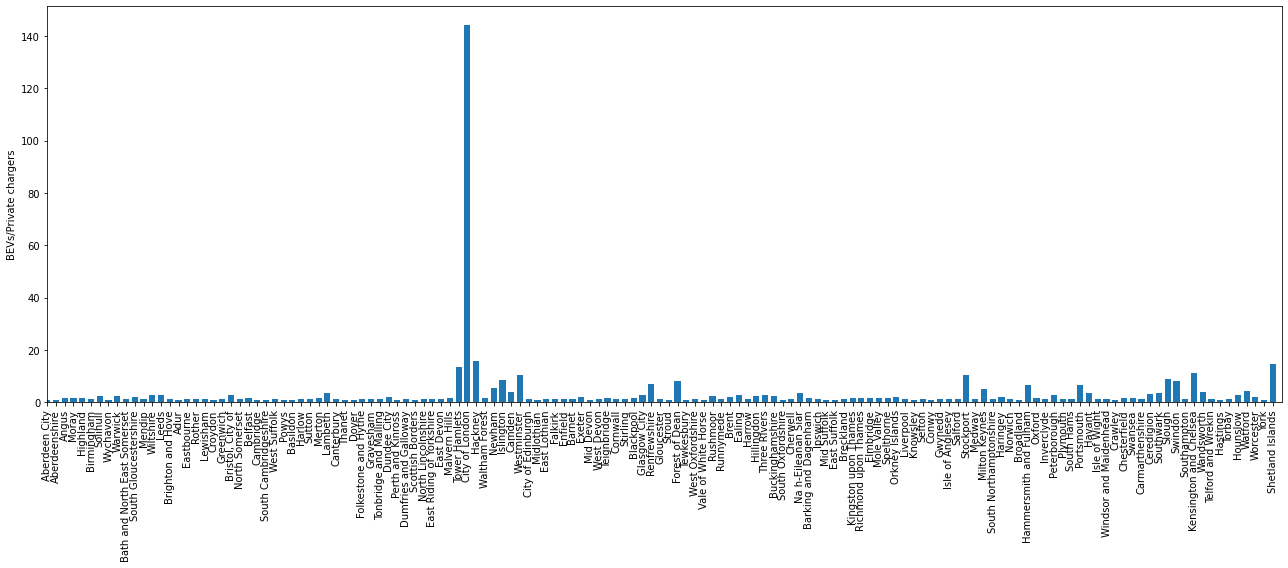

In [ ]:
x = np.arange(len(rsel))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
rects1 = ax.bar(x, rsel, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs/Private chargers')
#ax.set_title('BEVs  Devices Quarterly Trend')
ax.set_xticks(x)
ax.set_xlim(0,len(rsel))
ax.set_xticklabels(rsel.index, rotation = 90)
#ax.legend()

fig.tight_layout()

plt.show()

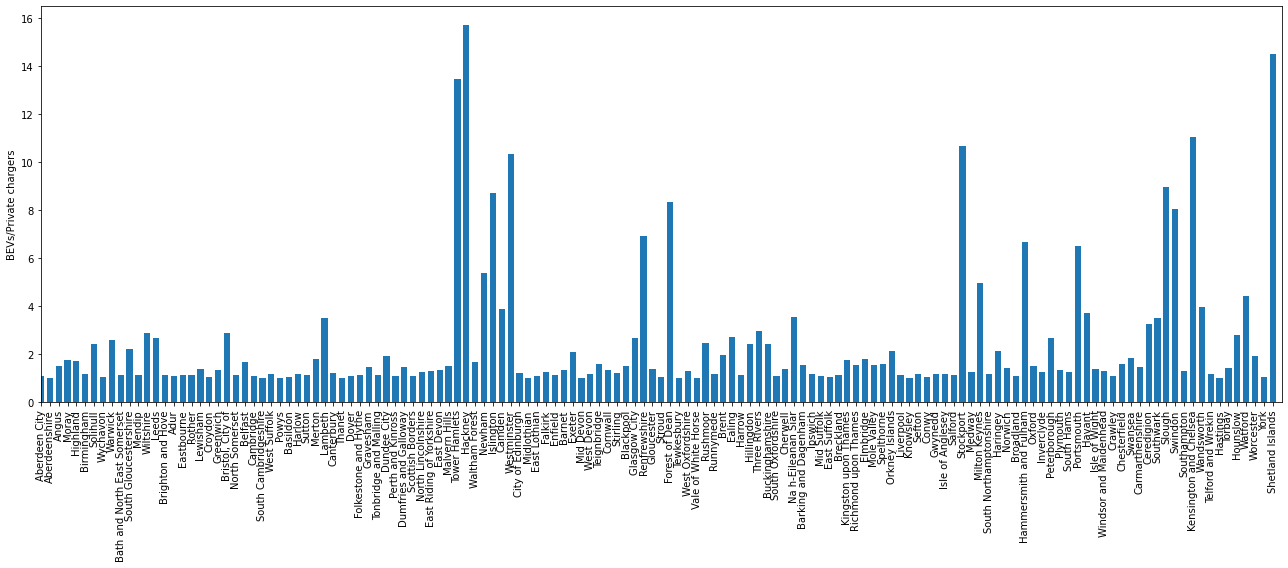

In [ ]:
data_set = rsel_withoutmax

x = np.arange(len(data_set))
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(18,8))
rects1 = ax.bar(x, data_set, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('BEVs/Private chargers')
#ax.set_title('BEVs  Devices Quarterly Trend')
ax.set_xticks(x)
ax.set_xlim(0,len(data_set))
ax.set_xticklabels(data_set.index, rotation = 90)
#ax.legend()

fig.tight_layout()

plt.show()

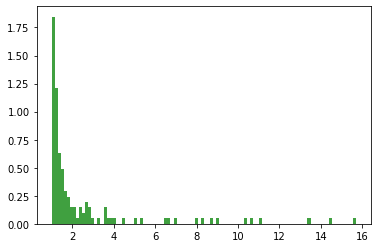

In [ ]:
plt.hist(rsel_withoutmax, 100, density=True, facecolor='g', alpha=0.75)
plt.show()

In [ ]:
#Top 10 Local Authorities with the highest BEVs/private chargers ratio
rsel.sort_values(ascending = False).head(10)

District
City of London            144.000000
Hackney                    15.704918
Shetland Islands           14.500000
Tower Hamlets              13.458333
Kensington and Chelsea     11.050955
Stockport                  10.656663
Westminster                10.328063
Slough                      8.978873
Islington                   8.735849
Forest of Dean              8.342577
dtype: float64

In [ ]:
#Bottom 10 Local Authorities with the highest BEVs/private chargers ratio
rsel.sort_values().head(10)

District
Tewkesbury              1.001029
South Cambridgeshire    1.003079
Vale of White Horse     1.007414
Hastings                1.009901
Thanet                  1.010929
Mid Devon               1.013986
Midlothian              1.015730
Knowsley                1.020501
Powys                   1.026071
Aberdeenshire           1.030233
dtype: float64

In [ ]:
summary_dataframe.loc['Brighton and Hove']

Population                                                                     273244
Total electric vehicles (BEVs)                                                    495
Total public charging devices                                                     227
Total public charging devices per 100,000 population                          78.0377
Total private charging devices                                                    438
Received government funding for residential charging devices                      Yes
Charging devices usage                                          Predomintantly public
Name: Brighton and Hove, dtype: object